In this notebook, we will be building our model for the open-world experiments to binary classify by determining whether the web traffic trace corresponds to a monitored website or unmonitored website.   

In [18]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Extracting Data

To begin, we will first import the dataframes into this notebook

In [19]:
with open('datasets/extracted_features.pkl', 'rb') as f:
    extracted_df = pickle.load(f)

We relabel the data such that monitored websites will be considered the positive samples and labelled as 1 and unmonitored websites will be considered the negative samples, labelled as 0.

In [20]:
relabelled_df = extracted_df.copy()
relabelled_df['label'] = relabelled_df['label'].apply(lambda x: 1 if x>=0 else x)

In [21]:
relabelled_df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,1,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,1,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,1,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,1,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,1,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
28995,-1,4180,413,4593,0.910081,0.089919,1173.380403,2549.414044,32.09,0.006987
28996,-1,4663,447,5110,0.912524,0.087476,1621.869237,3062.015660,38.62,0.007558
28997,-1,302,59,361,0.836565,0.163435,118.245320,179.101695,34.93,0.096759
28998,-1,413,96,509,0.811395,0.188605,166.667122,309.197917,11.84,0.023261


In [22]:
# Separating Labels and Features
X = relabelled_df.drop(columns=['label'])
y = relabelled_df['label']

# Splitting the data into training and test sets for our first experiments
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y)

# Feature Importance
We can use a first Random Forest model to study the feature importance using the sklearn library.


In [23]:
model_1= RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=42)
model_1.fit(X_train, y_train)
feature_imp_1 = pd.Series(model_1.feature_importances_, index=X.columns)



In [24]:
model_2= RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=42)
model_2.fit(X_train, y_train)
feature_imp_2 = pd.Series(model_2.feature_importances_, index=X.columns)

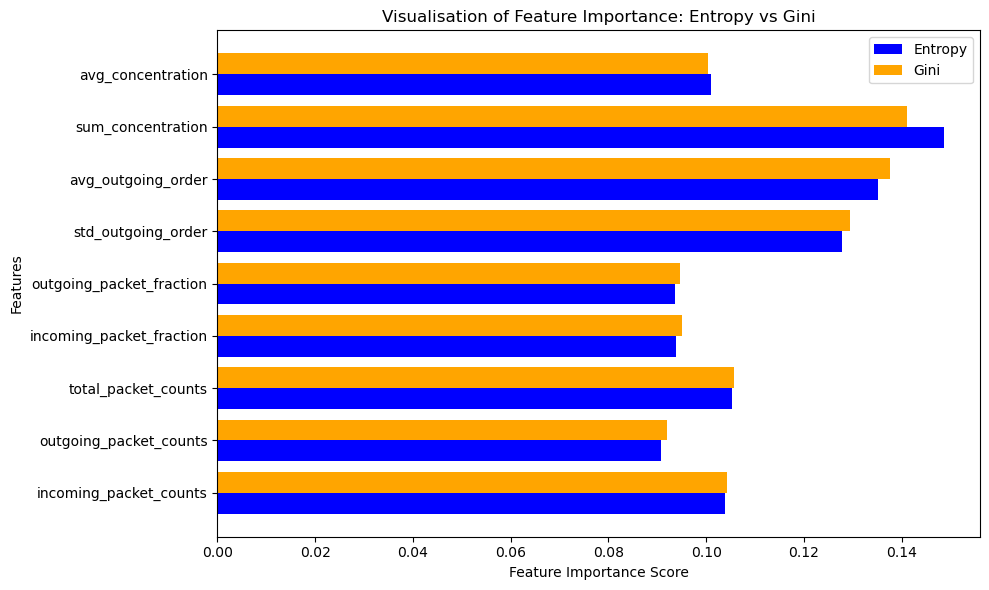

In [25]:
feature_names = feature_imp_1.index
entropy_values = feature_imp_1.values
gini_values = feature_imp_2.values

bar_width = 0.4 
y_positions = range(len(feature_names)) 

plt.figure(figsize=(10, 6))

#plotting entropy importance
plt.barh(
    [y - bar_width / 2 for y in y_positions],
    entropy_values,
    bar_width,
    label='Entropy',
    color='blue',
)

# plotting gini improtance
plt.barh(
    [y + bar_width / 2 for y in y_positions],
    gini_values,
    bar_width,
    label='Gini',
    color='orange',
)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.yticks(y_positions, feature_names) 
plt.title('Visualisation of Feature Importance: Entropy vs Gini')
plt.legend()
plt.tight_layout()
plt.show()

Recall the extracted features:
> **Feature Group 1: Traffic Volume (Absolute)**  
> - Feature 1: Number of incoming packets  
> - Feature 2: Number of outgoing packets  
> - Feature 3: Total number of packets  
> 
> **Feature Group 2: Traffic Volume (Fraction)**
> - Feature 1: Number of incoming packets as a fraction of the total number of packets  
> - Feature 2: Number of outgoing packets as a fraction of the total number of packets 
> 
> **Feature Group 3: Traffic Ordering List**
> - Feature 6: Standard deviation of the outgoing packets ordering list  
> - Feature 7: Average of the outgoing packets ordering list  
> 
> **Feature Group 4: Traffic concentration** 
> - Feature 8: Sum of all items in the alternative concentration feature list  
> - Feature 9: Average of all items in the alternative concentration feature list  

We noted that within each of the 4 feature groups, the features are likely to be highly correlated due to their similarity. Furthermore, feature groups 1 and 2 are closely related as well with 1 being an absolute measurement of traffic volume and 2 as the ratio. Hence we will be selecting 2 features from the combination of group 1 and 2, and 1 feature each from group 3 and 4.

According to our feature importance analysis, we can see that there are three 'top features' that seem to be relatively more significant than the other ones, using both gini and entropy. We can see however that avg outoing order and std outgoing order are from the same group. Considering this, we have selected the following features to build our model:
1. Feature 1: Number of incoming packets   
2. Feature 3: Total number of packets
3. Feature 7: Average of the outgoing packets ordering list 
4. Feature 8: Sum of all items in the alternative concentration feature list  

In [26]:
X = relabelled_df[['incoming_packet_counts', 'total_packet_counts', 'avg_outgoing_order', 'sum_concentration']]
y = relabelled_df['label']

# Constructing Model

In this section, we construct an arbitrary random forest classification model using arbitrarily chosen parameters or default parameters. This section aims to explore the implementation of the model. These parameters will be tuned in the next section. The configartion is to use gini impurity decrease to build 100 classifiers, with each having a maximum of features equal to the square root number of the total features which here is 2.  

In [27]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

In [28]:
# Training a model
model_3 = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=42)
model_3.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [29]:
# Testing it  --> change for 5-fold?

y_train_pred = model_3.predict(X_train)
y_test_pred = model_3.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Test Accuracy: 0.7410


In [30]:
print("Global Report for first test model (model_3)")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y_test,y_test_pred))


Global Report for first test model (model_3)
              precision    recall  f1-score   support

          -1       0.66      0.52      0.58      2000
           1       0.77      0.86      0.81      3800

    accuracy                           0.74      5800
   macro avg       0.72      0.69      0.70      5800
weighted avg       0.73      0.74      0.73      5800


Confusion Matrix
[[1037  963]
 [ 539 3261]]


As we are studying a binary classification, it is interesting to study the confusion matrix. We can think of a use case where monitored websites represent a specific kind of service for which we want to measure the frequence of access.

# Model Tuning

In [ ]:
param_grid_random = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_distributions=param_grid_random, 
    n_iter=50, 
    cv=5, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_random_params = random_search.best_params_
print("Best parameters from RandomizedSearchCV:", best_random_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']           
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,  
    refit=True, 
    verbose = 3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 15],
                         'n_estimators': [100, 150, 200]},
             verbose=3)

In [ ]:
# print best parameters after grid search
print(grid.best_params_)

# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 150}
RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=150, random_state=0)


In [ ]:
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8884
Test Accuracy: 0.7252


In [ ]:
print("Global Report for model tuned with grid search")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y_test,y_test_pred))

              precision    recall  f1-score   support

          -1       0.65      0.47      0.55      2044
           1       0.75      0.86      0.80      3756

    accuracy                           0.73      5800
   macro avg       0.70      0.67      0.68      5800
weighted avg       0.72      0.73      0.71      5800

